# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.


>**For å starte denne**:

* sette opp cuda http://expressionflow.com/2016/10/09/installing-tensorflow-on-an-aws-ec2-p2-gpu-instance/


## Project: Build a Traffic Sign Recognition Program
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
### Overview

In this project, you will use what you've learned about deep neural networks and convolutional neural networks to classify traffic signs. You will train a model so it can decode traffic signs from natural images by using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is trained, you will then test your model program on new images of traffic signs you find on the web, or, if you're feeling adventurous pictures of traffic signs you find locally!

### Dependencies

This project requires **Python 3.5** and the following Python libraries installed:

- [Jupyter](http://jupyter.org/)
- [NumPy](http://www.numpy.org/)
- [SciPy](https://www.scipy.org/)
- [scikit-learn](http://scikit-learn.org/)
- [TensorFlow](http://tensorflow.org)
- [Matplotlib](http://matplotlib.org/)
- [Pandas](http://pandas.pydata.org/) (Optional)

Run this command at the terminal prompt to install [OpenCV](http://opencv.org/). Useful for image processing:

- `conda install -c https://conda.anaconda.org/menpo opencv3`

### Dataset

1. [Download the dataset](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip). This is a pickled dataset in which we've already resized the images to 32x32.
2. Clone the project and start the notebook.
```
git clone https://github.com/udacity/CarND-Traffic-Signs
cd CarND-Traffic-Signs
jupyter notebook Traffic_Signs_Recognition.ipynb
```
3. Follow the instructions in the `Traffic_Signs_Recognition.ipynb` notebook.

In [1]:
%matplotlib inline
# imports
import pickle
import random
import math
import os
# find versions of libraries
import tensorflow as tf
print('The tensorflow version is {}.'.format(tf.__version__))
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from IPython.display import display

from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import cv2
print('The cv2 version is {}.'.format(cv2.__version__))
import scipy.stats as stats
import pylab as pl

# check the GPU
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
s = sess.run(c)



The tensorflow version is 0.12.1.
The scikit-learn version is 0.18.1.
The cv2 version is 3.1.0.


---
## Step 0: Load The Data

In [2]:
# Load pickled data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


In [3]:
# create a simple db to store an compare accuracies
sql_db = 'configtest.db'


def create_table():
    sql_conn = sqlite3.connect(sql_db)
    sql_cursor = sql_conn.cursor()
    sql_cursor.execute('''CREATE TABLE IF NOT EXISTS accuracy (date text, configuration text,  accuracy real)''')
    sql_conn.commit()
    sql_conn.close()

def log_accuracy(configuration, accuracy):
    delete_log(configuration)
    sql_conn = sqlite3.connect(sql_db)
    sql_cursor = sql_conn.cursor()
    n = datetime.now().isoformat()
    n = datetime.now().strftime('%Y-%m-%d %H:%M')
    sql_cursor.execute("INSERT INTO accuracy VALUES (?,?,?)",(n,configuration,accuracy))
    sql_conn.commit()
    sql_conn.close()
    
def get_log():
    sql_conn = sqlite3.connect(sql_db)
    sql_cursor = sql_conn.cursor()
    sql_cursor.execute("SELECT * from accuracy ORDER by accuracy DESC")
    all_rows = sql_cursor.fetchall()
    sql_conn.commit()
    sql_conn.close()
    return all_rows

def delete_log(configuration = 'ALL'):
    sql_conn = sqlite3.connect(sql_db)
    sql_cursor = sql_conn.cursor()
    if configuration == 'ALL':
        sql_cursor.execute("DELETE from accuracy")
    else:
        sql_cursor.execute("DELETE from accuracy where configuration=?",(configuration,))
    all_rows = sql_cursor.fetchall()
    sql_conn.commit()
    sql_conn.close()
    return 

def drop_table():
    sql_conn = sqlite3.connect(sql_db)
    sql_cursor = sql_conn.cursor()
    # Create table
    sql_cursor.execute('''DROP TABLE  accuracy ''')
    sql_conn.commit()
    sql_conn.close()

def display_log():
    rows =get_log();
    rowdf = pd.DataFrame(rows)
    pd.set_option('display.max_colwidth',80)
    rowdf = rowdf.rename(index=str,columns={0:'Time',1:'Configuration',2:'Test Accuracy'})
    display(rowdf)





configuration = 'VGG16 no7 normalized'
configuration = 'LeNet no7 normalized'
configuration = 'LeNet no7 normalized generatedwithdistributions'
configuration = 'LeNet no10 normalized generatedwithdistributions dropout3'


create_table()


display_log()

Time  \
0   2017-01-07 07:48   
1   2017-01-07 07:23   
2   2017-01-07 07:57   
3   2017-01-07 07:27   
4   2017-01-02 08:36   
5   2017-01-02 10:59   
6   2017-01-01 17:37   
7   2017-01-01 08:31   
8   2017-01-02 11:05   
9   2016-12-30 16:20   
10  2017-01-02 08:39   
11  2016-12-30 16:32   
12  2016-12-31 11:27   
13  2017-01-01 07:02   
14  2016-12-31 11:37   
15  2016-12-30 16:10   
16  2017-01-02 08:25   
17  2016-12-31 11:40   
18  2017-01-01 08:47   
19  2016-12-31 11:29   
20  2016-12-31 11:42   
21  2016-12-31 11:36   
22  2016-12-31 11:44   
23  2016-12-30 16:36   
24  2016-12-30 16:36   
25  2016-12-31 11:33   
26  2017-01-07 06:23   
27  2016-12-30 14:05   

                                                Configuration  Test Accuracy  
0             LeNet no7 normalized generatedwithdistributions       0.935709  
1                                        LeNet no7 normalized       0.921140  
2   LeNet no10 normalized generatedwithdistributions dropout3       0.920032  
3   LeNet no10 grayscaled generatedwithdistributions dropout3       0.917577  
4              LeNet no10 generatedwithdistributions dropout3       0.915123  
5            LeNet no10 normalized generatedwithdistributions       0.914806  
6             LeNet no1 normalized generatedwithdistributions       0.906334  
7                              LeNet no7 normalized generated       0.905938  
8                                                   LeNet no7       0.900792  
9                                          LeNet no7 dropout2       0.895566  
10              LeNet no7 generatedwithdistributions dropout3       0.895408  
11                                         LeNet no7 dropout3       0.892478  
12                                                  LeNet no8       0.889390  
13                                        LeNet no7 generated       0.879968  
14                                                  LeNet no2       0.869913  
15                                         LeNet no7 dropout1       0.863579  
16   LeNet no7 normalized generatedwithdistributions dropout3       0.862391  
17                                                  LeNet no5       0.858274  
18                    LeNet no7 normalized generated dropout1       0.851940  
19                                                  LeNet no1       0.851148  
20                                                  LeNet no6       0.846081  
21                                                  LeNet no4       0.725257  
22                                                  LeNet no9       0.064846  
23                               GradientDescentOptimizer no1       0.060333  
24                               GradientDescentOptimizer no1       0.060333  
25                                                  LeNet no3       0.057007  
26                                       VGG16 no7 normalized       0.054711  
27                                      AdadeltaOptimizer no1       0.019240

In [4]:

signs = pd.read_csv('./signnames.csv')
signs

ClassId                                            SignName
0         0                                Speed limit (20km/h)
1         1                                Speed limit (30km/h)
2         2                                Speed limit (50km/h)
3         3                                Speed limit (60km/h)
4         4                                Speed limit (70km/h)
5         5                                Speed limit (80km/h)
6         6                         End of speed limit (80km/h)
7         7                               Speed limit (100km/h)
8         8                               Speed limit (120km/h)
9         9                                          No passing
10       10        No passing for vehicles over 3.5 metric tons
11       11               Right-of-way at the next intersection
12       12                                       Priority road
13       13                                               Yield
14       14                                                Stop
15       15                                         No vehicles
16       16            Vehicles over 3.5 metric tons prohibited
17       17                                            No entry
18       18                                     General caution
19       19                         Dangerous curve to the left
20       20                        Dangerous curve to the right
21       21                                        Double curve
22       22                                          Bumpy road
23       23                                       Slippery road
24       24                           Road narrows on the right
25       25                                           Road work
26       26                                     Traffic signals
27       27                                         Pedestrians
28       28                                   Children crossing
29       29                                   Bicycles crossing
30       30                                  Beware of ice/snow
31       31                               Wild animals crossing
32       32                 End of all speed and passing limits
33       33                                    Turn right ahead
34       34                                     Turn left ahead
35       35                                          Ahead only
36       36                                Go straight or right
37       37                                 Go straight or left
38       38                                          Keep right
39       39                                           Keep left
40       40                                Roundabout mandatory
41       41                                   End of no passing
42       42  End of no passing by vehicles over 3.5 metric tons

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [5]:
### Replace each question mark with the appropriate value.

# train data types
print('train keys',train.keys())
print('y_train.shape:',y_train.shape)
print('X_train.shape: ',X_train.shape)
print('y_train: ',y_train)
# the pixels are 3 channels of integers
print('A random pixel: ',X_train[0][5,5,:])


# TODO: Number of training examples
n_train = len(y_train)
# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?

_,x,y,_ = X_train.shape
image_shape = (x,y)

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

train keys dict_keys(['labels', 'sizes', 'coords', 'features'])
y_train.shape: (39209,)
X_train.shape:  (39209, 32, 32, 3)
y_train:  [ 0  0  0 ..., 42 42 42]
A random pixel:  [195  82  82]
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [6]:
def display_image(signlist,X,y,use_signs=True):
    plt.figure(figsize=(12,12))
    gs1 = gridspec.GridSpec(int(math.ceil(len(signlist)/4)+1),4)
    #gs1 = gridspec.GridSpec(3,4)
    gs1.update(wspace=0.1, hspace=0.01) 
    i = 0
    for signno in signlist:
        itemindex = np.where(y_train==signno)
        index = itemindex[0][0]
        image = X[index].squeeze()  
        ax1 = plt.subplot(gs1[i])
        i += 1
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.axis('off')
        plt.imshow(image)
        if use_signs:
            text = '{}:{}'.format(y[index],signs.iloc[signno]['SignName'])
            #print(text)
            plt.text(2,4,text,color='k',backgroundcolor='y',fontsize = 6)
    

#display_image([1,2])

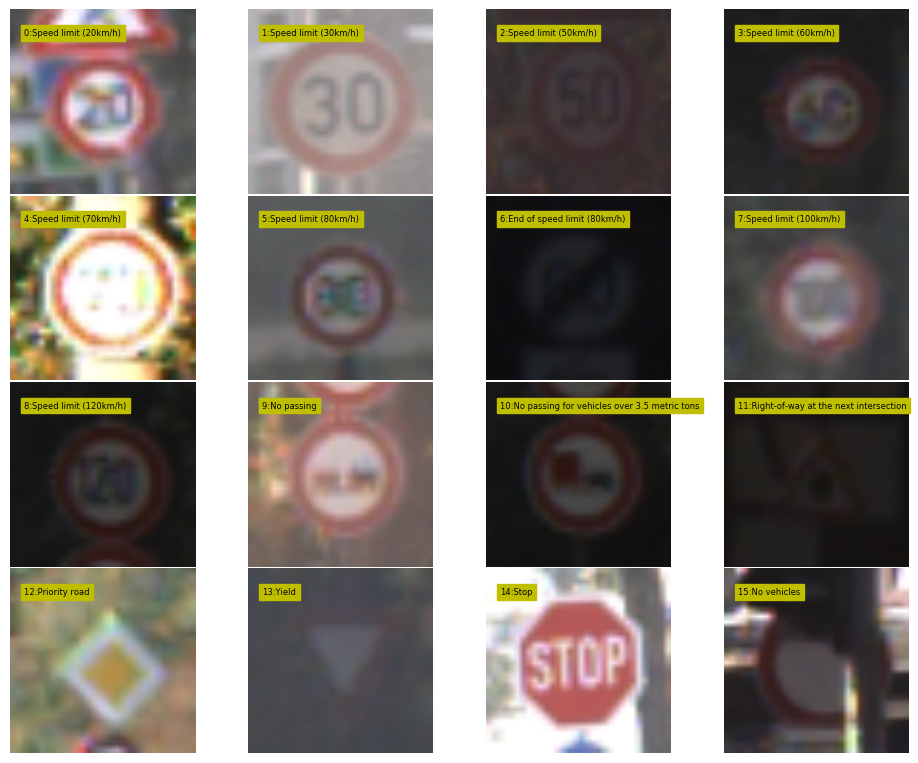

In [7]:
images = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
images = [i for i in images]
display_image(images,X_train,y_train)

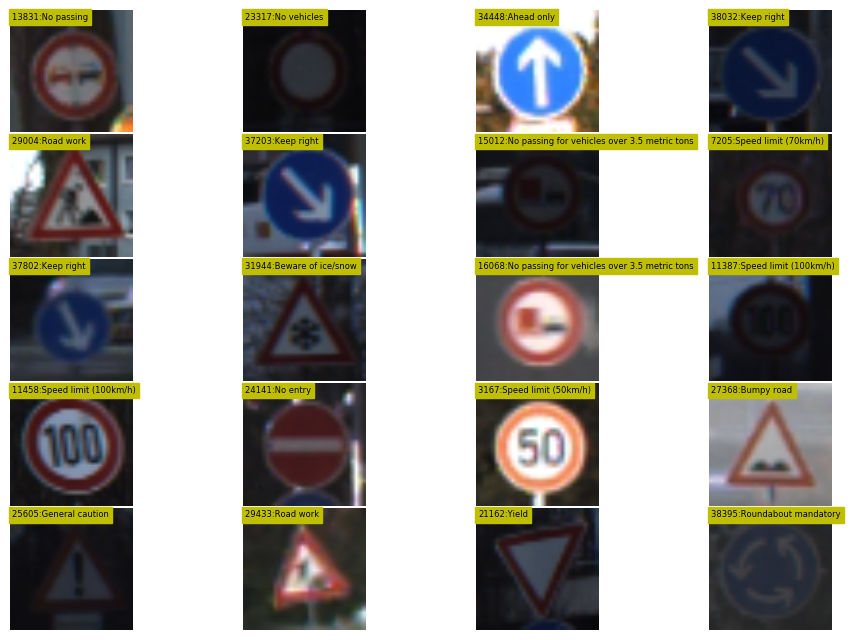

In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
## added som more cells


# a random set of images
sample_signs = random.sample(range(1,n_train), 20)


def plot_signs(sample_signs,x,y,signs, use_signs=True):
    
    plt.figure(figsize = (12,8))
    gs1 = gridspec.GridSpec(int(math.ceil(len(sample_signs)/4)),4)

    gs1.update(wspace=0.01, hspace=0.02) 

    for i in range(len(sample_signs)):
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.imshow(x[sample_signs[i]])
        if use_signs:
            text = '{}:{}'.format(sample_signs[i],signs.iloc[y[sample_signs[i]]]['SignName'])
            plt.text(0,2,text,color='k',backgroundcolor='y',fontsize = 6)
        plt.axis('off')
    plt.show()

plot_signs(sample_signs,X_train,y_train,signs)

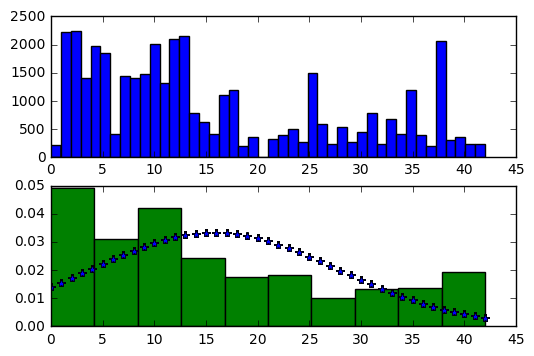

In [9]:
# see the distribution of train signs
plt.subplot(2, 1, 1)
pl.hist(y_train,bins=44) 

plt.subplot(2, 1, 2)
 
fit = stats.norm.pdf(y_train, np.mean(y_train), np.std(y_train))  
pl.plot(y_train,fit,'*')

pl.hist(y_train,normed=True)     
pl.show()



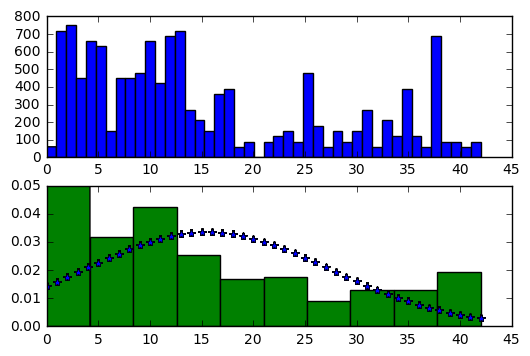

In [10]:
# see the distribution of test signs
plt.subplot(2, 1, 1)
pl.hist(y_test,bins=44) 

plt.subplot(2, 1, 2)
 
fit = stats.norm.pdf(y_test, np.mean(y_test), np.std(y_test))  
pl.plot(y_test,fit,'*')

pl.hist(y_test,normed=True)     
pl.show()



#### Comment:
We see that some of the signs are dark, and that some of the signs are more frequent than others.

Also that the profile of frequency is the same in training set and test set.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Normalized


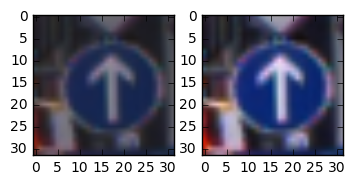

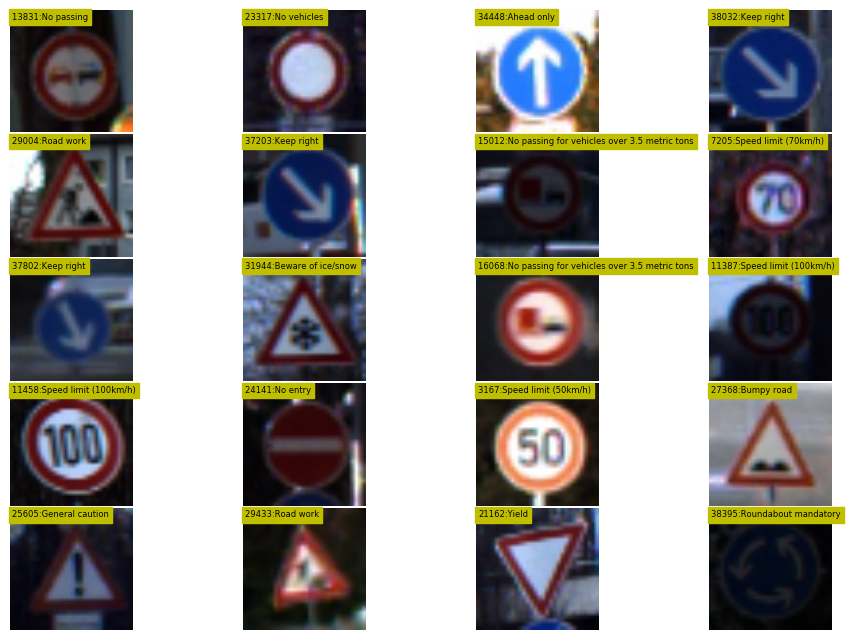

In [11]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
# normalize

# find a sample image, see the difference when doing a normalization
index = 34333
plt.figure(figsize=(4,4))
image = X_train[index].squeeze()
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
im2 = np.copy(image)
im2 = cv2.normalize(image,im2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(im2)

plt.subplot(1, 2, 2)
im2 = np.copy(image)
im2 = cv2.normalize(image,im2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(im2)


# normalise and change pixels to float
def normalize(imageset):
    newset = np.copy(imageset)
    newset = np.array([cv2.normalize(imageset[i],newset[i], alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) for i in range(len(imageset))],dtype = np.float32)
    return newset

# normalise and change pixels to float
def greyscale(imageset):
    newset = np.copy(imageset)
    newset = np.array([cv2.cvtColor(imageset[i],cv2.COLOR_RGB2BGR) for i in range(len(imageset))],dtype = np.float32)
    newset = np.array([cv2.cvtColor(imageset[i],cv2.COLOR_BGR2GRAY) for i in range(len(imageset))],dtype = np.float32)
    n,r,c = newset.shape
    newset2 = np.empty((n,r,c,3))
    newset2[:,:,:,1] = newset
    return newset2



if "normalized" in configuration:
    X_train = normalize(X_train)
    X_test = normalize(X_test)
    print('Normalized') 

if "grayscaled" in configuration:
    Xn_train = greyscale(X_train)
    Xn_test = greyscale(X_test)
    print('Grayscaled') 


plot_signs(sample_signs,X_train,y_train,signs)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_


**Answer:**


1. Started by shuffling the data, to avoid biases based on the order
1. Normalized the images with 2 different techniques. To make them clearer, but also to change them to float as I had problems when the numpy arrays where integers. Got a hint from my mentor about normalization routines in cv2


generated data with distributions
y_train.shape: (158725,)
X_train.shape:  (158725, 32, 32, 3)


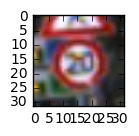

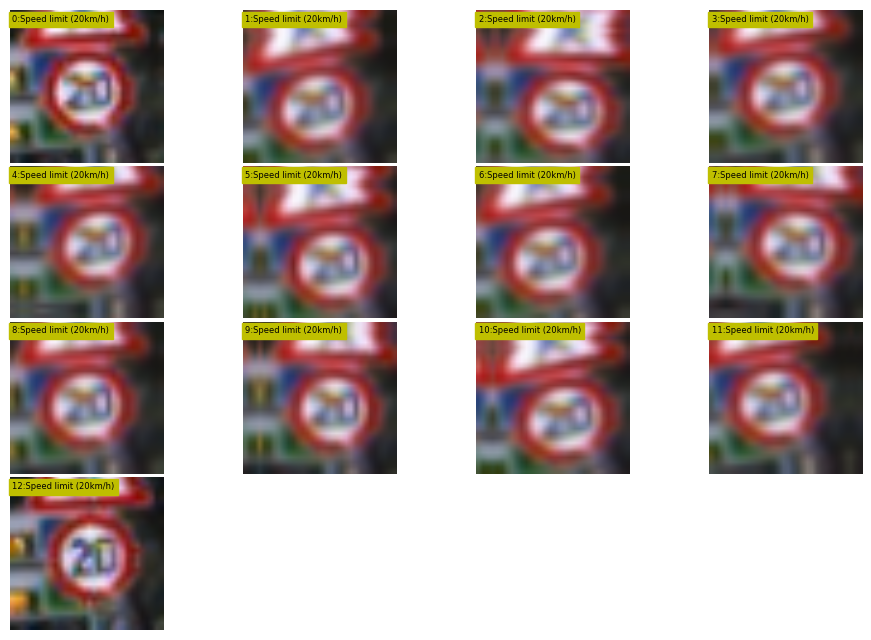

In [12]:
### Generate data additional data (OPTIONAL!)

def new_image(image):
    newimage = np.copy(image)
    rows,cols,channels = image.shape 
    
    # Shear
    p1 = np.float32([[5,5],[20,5],[5,20]])
    p21 = 2*np.random.uniform()
    p22 = 2*np.random.uniform()
    p2 = np.float32([[5-p21,5+p22],[20,5],[5-p21,20+p22]])
    shear = cv2.getAffineTransform(p1,p2)
    newimage = cv2.warpAffine(newimage,shear,(cols,rows),None,flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    # Rotation
    rotation = np.random.uniform(-10,10)
    rotation = cv2.getRotationMatrix2D((cols/2,rows/2),rotation,1)
    newimage = cv2.warpAffine(newimage,rotation,(cols,rows),None,flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    # Apply the Affine Transform just found to the src image

    # move
    x = np.random.uniform(-4,4)
    y = np.random.uniform(-4,4)
    trans = np.float32([[1,0,x],[0,1,y]])
    newimage = cv2.warpAffine(newimage,trans,(cols,rows),None,flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    
   
    return newimage


def generate_data(X_train,y_train,copies = 1):
    Xn = []
    yn = []   
    for i in range(len(y_train)):
        Xn.append(X_train[i])
        yn.append(y_train[i])
        for j in range(copies):
            newimage = new_image(X_train[i])
            Xn.append(newimage)
            yn.append(y_train[i])
            
    Xn = np.array(Xn,dtype = np.float32)
    yn = np.array(yn,dtype = np.int) 
    plt.subplot(3, 1, 1)
    plt.imshow(X_train[0])
    return Xn,yn

def generate_data_with_distribution(X_train,y_train):
    values, counts = np.unique(y_train, return_counts=True)
    max_counts = max(counts)
    distribution_dict = dict(zip(values,counts))

    Xn = []
    yn = []   
    for i in range(len(y_train)):
        Xn.append(X_train[i])
        yn.append(y_train[i])
        for j in range(math.ceil(max_counts/distribution_dict[y_train[i]])):
            newimage = new_image(X_train[i])
            Xn.append(newimage)
            yn.append(y_train[i])
            
    Xn = np.array(Xn,dtype = np.float32)
    yn = np.array(yn,dtype = np.int) 
    plt.subplot(3, 1, 1)
    plt.imshow(X_train[0])
    return Xn,yn


if 'generatedwithdistributions' in configuration:
    
    Xn_train,yn_train = generate_data_with_distribution(X_train,y_train)
    X_train = Xn_train
    y_train = yn_train
    print('generated data with distributions')
elif 'generated' in configuration:
    Xn_train,yn_train = generate_data(X_train,y_train,10)
    X_train = Xn_train
    y_train = yn_train
    print('generated data')
else:
    print('no generatation of data')

print('y_train.shape:',y_train.shape)
print('X_train.shape: ',X_train.shape)


plot_signs([0,1,2,3,4,5,6,7,8,9,10,11,12],X_train,y_train,signs)

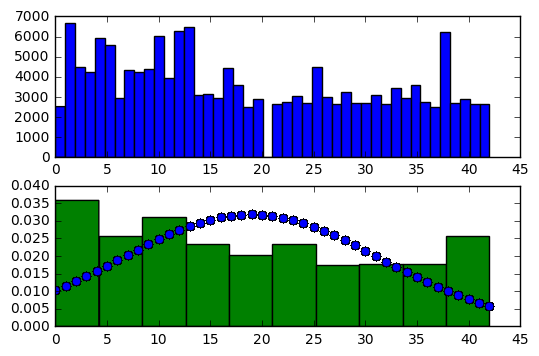

In [13]:
# see the distribution of train signs afterwards
plt.subplot(2, 1, 1)
pl.hist(y_train,bins=44) 

plt.subplot(2, 1, 2)
 
fit = stats.norm.pdf(y_train, np.mean(y_train), np.std(y_train))  
pl.plot(y_train,fit,'o')

pl.hist(y_train,normed=True)     
pl.show()



In [14]:


### and split the data into training/validation/testing sets here.

print('X_train and y_train.shape, before the split: ',X_train.shape,'  --  ',y_train.shape)
#from sklearn.cross_validation import train_test_split  # sklearn 0.17.x
from sklearn.model_selection import train_test_split 
X_train,X_validation,y_train,y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print('X_train.shape: ',X_train.shape)
print('y_train.shape: ',y_train.shape)
print('X_validation.shape: ',X_validation.shape)
print('y_validation.shape: ',y_validation.shape)




X_train and y_train.shape, before the split:  (158725, 32, 32, 3)   --   (158725,)
X_train.shape:  (142852, 32, 32, 3)
y_train.shape:  (142852,)
X_validation.shape:  (15873, 32, 32, 3)
y_validation.shape:  (15873,)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. Kept test data as is, normalized, when I normalized the training data
1. Split training data into training data and validation data set
1. Added copies that where rotated and skewed to generate more data, got hints from co-students on how to generate more data
1. Added more where there where few copies, as the distribution where off 

In [15]:


def LeNet_withDropout(x):    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Apply Dropout
    fc0 = tf.nn.dropout(fc0, dropout)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84,n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [16]:


def LeNet(x):    

    print("build model started")
    
    VGG_MEAN = [103.939, 116.779, 123.68]
    rgb_scaled = x * 255.0
    #Cinvert RGB to BGR
    red, green, blue = tf.split(3, 3, rgb_scaled)
    bgr = tf.concat(3, [
        blue - VGG_MEAN[0],
        green - VGG_MEAN[1],
        red - VGG_MEAN[2],
    ])
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    with tf.variable_scope('conv1'):
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(bgr, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84,n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    print("build model ended")
    
    return logits

In [17]:
# used code from https://github.com/machrisaa/tensorflow-vgg/
 
def VGG16(x):
    

    def get_conv_var(filter_size, in_channels, out_channels, name):
        initial_value = tf.truncated_normal([filter_size, filter_size, in_channels, out_channels], mean = mu, stddev = sigma)
        filters = tf.Variable(initial_value,  name + "_filters")
        initial_value = tf.truncated_normal([out_channels], mean = mu, stddev = sigma)
        biases = tf.Variable(initial_value, name + "_biases")
        return filters, biases
    
    def get_fc_var( in_size, out_size, name):
        initial_value = tf.truncated_normal([in_size, out_size], mean = mu, stddev = sigma)
        weights = tf.Variable(initial_value, name + "_weights")
        initial_value = tf.truncated_normal([out_size], mean = mu, stddev = sigma)
        biases = tf.Variable(initial_value, name + "_biases")
        return weights, biases
    

    def max_pool(bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(bottom, in_channels, out_channels, name):
        with tf.variable_scope(name):
            filt, conv_biases = get_conv_var(3, in_channels, out_channels, name)
            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')
            bias = tf.nn.bias_add(conv, conv_biases)
            relu = tf.nn.relu(bias)
            return relu

    def fc_layer(bottom, in_size, out_size, name):
        with tf.variable_scope(name):
            weights, biases = get_fc_var(in_size, out_size, name)

            x = tf.reshape(bottom, [-1, in_size])
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc


    #Layer 1: Convolutional. Input = 32x32x3. Output = 64x64x3.
    #resize images to
    #resize to vgg16 224x224x3
    VGG_MEAN = [103.939, 116.779, 123.68]
    x1 = tf.image.resize_images(x, [224,224])
    
        
    print("build model started")
    rgb_scaled = x1 * 255.0
    #Cinvert RGB to BGR
    red, green, blue = tf.split(3, 3, rgb_scaled)
    assert red.get_shape().as_list()[1:] == [224, 224, 1]
    assert green.get_shape().as_list()[1:] == [224, 224, 1]
    assert blue.get_shape().as_list()[1:] == [224, 224, 1]
    bgr = tf.concat(3, [
        blue - VGG_MEAN[0],
        green - VGG_MEAN[1],
        red - VGG_MEAN[2],
    ])
    assert bgr.get_shape().as_list()[1:] == [224, 224, 3]

    conv1_1 = conv_layer(bgr, 3, 64, "conv1_1")
    conv1_2 = conv_layer(conv1_1, 64, 64, "conv1_2")
    pool1 = max_pool(conv1_2, 'pool1')

    conv2_1 = conv_layer(pool1, 64, 128, "conv2_1")
    conv2_2 = conv_layer(conv2_1, 128, 128, "conv2_2")
    pool2 = max_pool(conv2_2, 'pool2')

    conv3_1 = conv_layer(pool2, 128, 256, "conv3_1")
    conv3_2 = conv_layer(conv3_1, 256, 256, "conv3_2")
    conv3_3 = conv_layer(conv3_2, 256, 256, "conv3_3")
    conv3_4 = conv_layer(conv3_3, 256, 256, "conv3_4")
    pool3 = max_pool(conv3_4, 'pool3')

    conv4_1 = conv_layer(pool3, 256, 512, "conv4_1")
    conv4_2 = conv_layer(conv4_1, 512, 512, "conv4_2")
    conv4_3 = conv_layer(conv4_2, 512, 512, "conv4_3")
    conv4_4 = conv_layer(conv4_3, 512, 512, "conv4_4")
    pool4 = max_pool(conv4_4, 'pool4')

    conv5_1 = conv_layer(pool4, 512, 512, "conv5_1")
    conv5_2 = conv_layer(conv5_1, 512, 512, "conv5_2")
    conv5_3 = conv_layer(conv5_2, 512, 512, "conv5_3")
    conv5_4 = conv_layer(conv5_3, 512, 512, "conv5_4")
    pool5 = max_pool(conv5_4, 'pool5')

    fc6 = fc_layer(pool5, 25088, 4096, "fc6")  # 25088 = ((224 / (2 ** 5)) ** 2) * 512
    relu6 = tf.nn.relu(fc6)

    #relu6 = tf.nn.dropout(relu6, 0.5)
    
    fc7 = fc_layer(relu6, 4096, 4096, "fc7")
    relu7 = tf.nn.relu(fc7)

    #relu7 = tf.nn.dropout(relu7, 0.5)
    
    fc8 = fc_layer(relu7, 4096, n_classes, "fc8")
    print("build model ended")
        
    
    return fc8




In [18]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
### Configured different permutations of hyperparameters and 


EPOCHS = 10
BATCH_SIZE = 128 
rate = 0.001
mu = 0
sigma = 0.1
dropout = 0.5

cnn = LeNet
sessname = 'LeNet'

if 'no2' in configuration:
    BATCH_SIZE =  256
elif 'no3' in configuration:
    rate = 0.01
elif 'no4' in configuration:
    rate = 0.0001
elif 'no5' in configuration:
    EPOCHS = 35
    rate = 0.0001
elif 'no6' in configuration:
    sigma = 0.2
elif 'no7' in configuration:
    sigma = 0.05
elif 'no8' in configuration:
    sigma = 0.01
elif 'no9' in configuration:
    sigma = 0.05
    mu = 0.05
elif 'no10' in configuration:
    sigma = 0.05
    EPOCHS = 25
    

    
if 'dropout1' in configuration:
    cnn = LeNet_withDropout
elif 'dropout2' in configuration:   
    dropout = 0.75
    cnn = LeNet_withDropout
elif 'dropout3' in configuration:   
    dropout = 0.8
    cnn = LeNet_withDropout
else: # configuration == 'no1' # default
    pass

if 'VGG16' in configuration:
    BATCH_SIZE = 64 
    cnn = VGG16
    sessname = 'VGG16'
    
print('Configuration: ', configuration)


Configuration:  LeNet no10 normalized generatedwithdistributions dropout3


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

1. Started by copying LeNet from videos. Then I modified depth and output classes. I also added a variant with dropout.
1. The architeture of LeNet is well described architecture consisting of a 2 times a pipeline of a convolutional neural network, activated by a rectified linear function, pooled in max_pool; then the network is flattened into a fully connected layer, activated with a rectified linear function and then another fully connected layer and then softmax. The softmax is actually is actually done in the cross_entropy function. 
1. the dimentions used are:
  1. The input to the first CNN layer is 32x32x1, and the output is 28x28x6.
  1. The input to the first pooling layer is 28x28x6, and the output is 14x14x6
  1. The input to the second CNN layer is 14x16x6 and the output is 10x10x16
  1. The input to the second pooling layer is 10x10x16 and the output is 5x5x16
  1. The network is then flattend into a 400 fully connected layer
  1. The fully connected layer is shaped into a 120 fully connected layer
  1. The next fully connected layer is shaped into a 84 wide layer
  1. Finally this is shaped into the number of classes we want: 43
1. I then created a variant where I introduced a droppout stage before I flattened out the network.
1. I also implemented a VGG16 network, with very different architecture. I got very poor perfomance from this network. I do not understand why it was this poor. I'd appreciate some hints in what I do not understand.

  

In [19]:
### Train your model here.
### Feel free to use as many code cells as needed


# copy from mnist notebook
# Features and Labels

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# copy from mnist notebook
# Training Pipeline

logits = cnn(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [20]:
# copy from mnist notebook
#Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [21]:


# copy from mnist notebook

#Train the Model¶
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./logs/' + configuration, sess.graph)
    num_examples = len(X_train)
    
    print("Training...")
    startTime = datetime.now()
    print('start =', startTime)
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        tf.summary.scalar('accuracy', validation_accuracy)
        
        
        print("EPOCH {} - Validation Accuracy = {:.3f}, Time = {}".format(i+1,validation_accuracy, datetime.now()-startTime))
        startTime = datetime.now()
    merged = tf.summary.merge_all()
    saver.save(sess, sessname)
    print("Model saved")

Training...
start = 2017-01-07 08:28:28.127731

EPOCH 1 - Validation Accuracy = 0.697, Time = 0:00:21.914031
EPOCH 2 - Validation Accuracy = 0.845, Time = 0:00:21.246712
EPOCH 3 - Validation Accuracy = 0.888, Time = 0:00:21.060709
EPOCH 4 - Validation Accuracy = 0.908, Time = 0:00:21.060334
EPOCH 5 - Validation Accuracy = 0.926, Time = 0:00:20.929202
EPOCH 6 - Validation Accuracy = 0.937, Time = 0:00:20.967797
EPOCH 7 - Validation Accuracy = 0.939, Time = 0:00:21.080981
EPOCH 8 - Validation Accuracy = 0.948, Time = 0:00:20.919372
EPOCH 9 - Validation Accuracy = 0.948, Time = 0:00:20.870858
EPOCH 10 - Validation Accuracy = 0.953, Time = 0:00:20.925341
EPOCH 11 - Validation Accuracy = 0.954, Time = 0:00:20.866687
EPOCH 12 - Validation Accuracy = 0.954, Time = 0:00:21.012916
EPOCH 13 - Validation Accuracy = 0.960, Time = 0:00:21.091616
EPOCH 14 - Validation Accuracy = 0.958, Time = 0:00:20.898599
EPOCH 15 - Validation Accuracy = 0.961, Time = 0:00:21.049816
EPOCH 16 - Validation Accuracy 

In [22]:
# copy from mnist notebook
# Evaluate the Model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    
    test_accuracy = evaluate(X_test, y_test)
    print("Configuration = '{}', Test Accuracy = {:.3f}".format(configuration,test_accuracy))
    log_accuracy(configuration,test_accuracy)

display_log()

Configuration = 'LeNet no10 normalized generatedwithdistributions dropout3', Test Accuracy = 0.926


Time  \
0   2017-01-07 07:48   
1   2017-01-07 08:37   
2   2017-01-07 07:23   
3   2017-01-07 07:27   
4   2017-01-02 08:36   
5   2017-01-02 10:59   
6   2017-01-01 17:37   
7   2017-01-01 08:31   
8   2017-01-02 11:05   
9   2016-12-30 16:20   
10  2017-01-02 08:39   
11  2016-12-30 16:32   
12  2016-12-31 11:27   
13  2017-01-01 07:02   
14  2016-12-31 11:37   
15  2016-12-30 16:10   
16  2017-01-02 08:25   
17  2016-12-31 11:40   
18  2017-01-01 08:47   
19  2016-12-31 11:29   
20  2016-12-31 11:42   
21  2016-12-31 11:36   
22  2016-12-31 11:44   
23  2016-12-30 16:36   
24  2016-12-30 16:36   
25  2016-12-31 11:33   
26  2017-01-07 06:23   
27  2016-12-30 14:05   

                                                Configuration  Test Accuracy  
0             LeNet no7 normalized generatedwithdistributions       0.935709  
1   LeNet no10 normalized generatedwithdistributions dropout3       0.926366  
2                                        LeNet no7 normalized       0.921140  
3   LeNet no10 grayscaled generatedwithdistributions dropout3       0.917577  
4              LeNet no10 generatedwithdistributions dropout3       0.915123  
5            LeNet no10 normalized generatedwithdistributions       0.914806  
6             LeNet no1 normalized generatedwithdistributions       0.906334  
7                              LeNet no7 normalized generated       0.905938  
8                                                   LeNet no7       0.900792  
9                                          LeNet no7 dropout2       0.895566  
10              LeNet no7 generatedwithdistributions dropout3       0.895408  
11                                         LeNet no7 dropout3       0.892478  
12                                                  LeNet no8       0.889390  
13                                        LeNet no7 generated       0.879968  
14                                                  LeNet no2       0.869913  
15                                         LeNet no7 dropout1       0.863579  
16   LeNet no7 normalized generatedwithdistributions dropout3       0.862391  
17                                                  LeNet no5       0.858274  
18                    LeNet no7 normalized generated dropout1       0.851940  
19                                                  LeNet no1       0.851148  
20                                                  LeNet no6       0.846081  
21                                                  LeNet no4       0.725257  
22                                                  LeNet no9       0.064846  
23                               GradientDescentOptimizer no1       0.060333  
24                               GradientDescentOptimizer no1       0.060333  
25                                                  LeNet no3       0.057007  
26                                       VGG16 no7 normalized       0.054711  
27                                      AdadeltaOptimizer no1       0.019240

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
See above for different configurations. 

I got pretty similar results whether i generated more data or not, or whether I used droppouts or not. Normalization was used to better classify the new images introduced below.


My final configuration was a LeNet architecture with
*  extra images, generated more where there was few images in the original dataset
* 25 EPOCHS or full itaration when training
* a batch size of 128 images
* using a sigma value of 0.05 and mu of 0 in for initial values of the weights
* a dropout with 0.8 as keep probality



### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Very much trial and error.

Starting off with LeNet was quick, then trial and error, trying different approaches.

The  first model is same parameters as LeNet. 

1. adjusting only the input and output parameters
1. tried different hyperparameters
1. tried different optimizers 
1. tried to normalize the data
1. tried to generate new data by transforming and rotating the images
1. the best I got was the "out of the box" LeNet, no generated data, nor  dropout

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

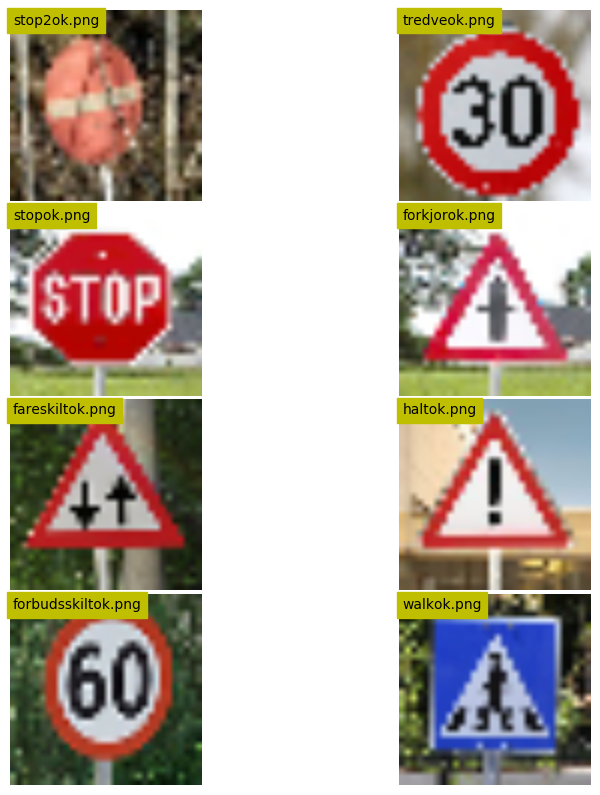

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
def plot_webimages(images,names):
    
    plt.figure(figsize = (10,10))
    gs1 = gridspec.GridSpec(4,int(math.ceil(len(images)/4)))
    gs1.update(wspace=0.01, hspace=0.02) 

    for i in range(len(images)):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.axis('off')
        plt.imshow(images[i])
        plt.text(0,2,names[i],color='k',backgroundcolor='y')
    plt.show()

def read_image(filename):
    newimage = cv2.imread(filename)
    newimage = cv2.resize(newimage,(32,32))
    newimage = cv2.cvtColor(newimage,cv2.COLOR_BGR2RGB)
    newimage = cv2.normalize(newimage,newimage, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return newimage




newimages = np.array([read_image("./skilt/"+name) for name in os.listdir("./skilt/")],dtype=np.float32)
newimagesnames = [name for name in os.listdir("./skilt/")]


plot_webimages(newimages,newimagesnames)



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

1. The *no entry* sign (stop2ok.png) is slightly discoloured, old and partly covered with vegetation.
1. The *passing* sign (walkok.png) seem not to be in the training nor test set
1. I have used norwegian signs :)

In [24]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
feed_dict_new = {x:newimages}

prediction=tf.argmax(logits,1)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction,feed_dict = feed_dict_new)

predictions




array([12,  1, 14, 27, 28, 18,  5, 38])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


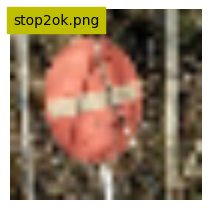

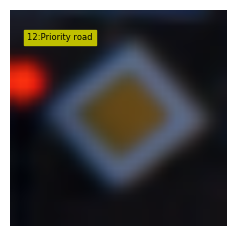

In [25]:
#first
i = 0
plot_webimages([newimages[i]],[newimagesnames[i]])
display_image([predictions[i]],X_train,y_train)

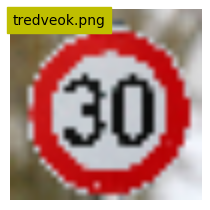

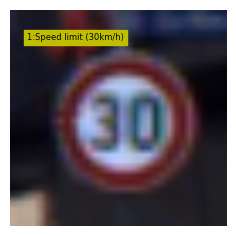

In [26]:

i = 1
plot_webimages([newimages[i]],[newimagesnames[i]])
display_image([predictions[i]],X_train,y_train)

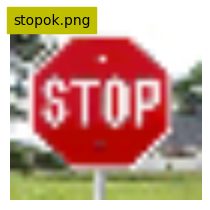

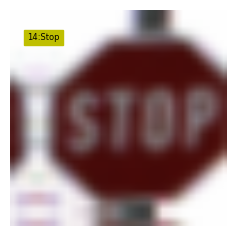

In [27]:

i = 2
plot_webimages([newimages[i]],[newimagesnames[i]])
display_image([predictions[i]],X_train,y_train)

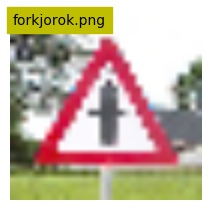

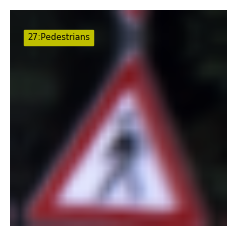

In [28]:

i = 3
plot_webimages([newimages[i]],[newimagesnames[i]])
display_image([predictions[i]],X_train,y_train)

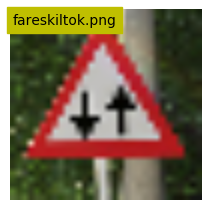

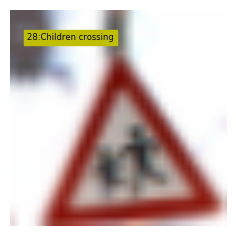

In [29]:

i = 4
plot_webimages([newimages[i]],[newimagesnames[i]])
display_image([predictions[i]],X_train,y_train)

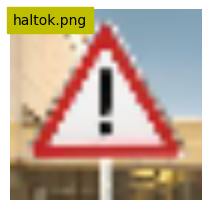

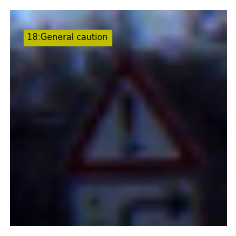

In [30]:

i = 5
plot_webimages([newimages[i]],[newimagesnames[i]])
display_image([predictions[i]],X_train,y_train)

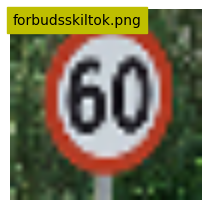

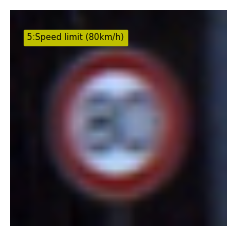

In [31]:

i = 6
plot_webimages([newimages[i]],[newimagesnames[i]])
display_image([predictions[i]],X_train,y_train)

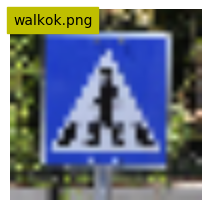

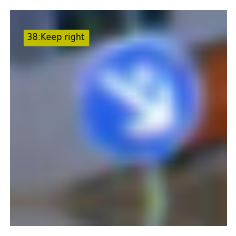

In [32]:

i = 7
plot_webimages([newimages[i]],[newimagesnames[i]])
display_image([predictions[i]],X_train,y_train)

**Answer:**

Predictions where from 0.25 to 0.5, not so good :) This is lower than the results on the test data. However if I compare only the signs that are in the training set I get 4 out of 6 correct, a result of 0.67 that are smaller than the result from test test set (0.91).


The one I was really disapointed at was that the 60km sign sometimes  was classified as a 50km sign... hmm

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [33]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

feed_dict_new = {x:newimages}
top = tf.nn.top_k(logits, 3)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_predictions = sess.run([logits, top], feed_dict=feed_dict_new)



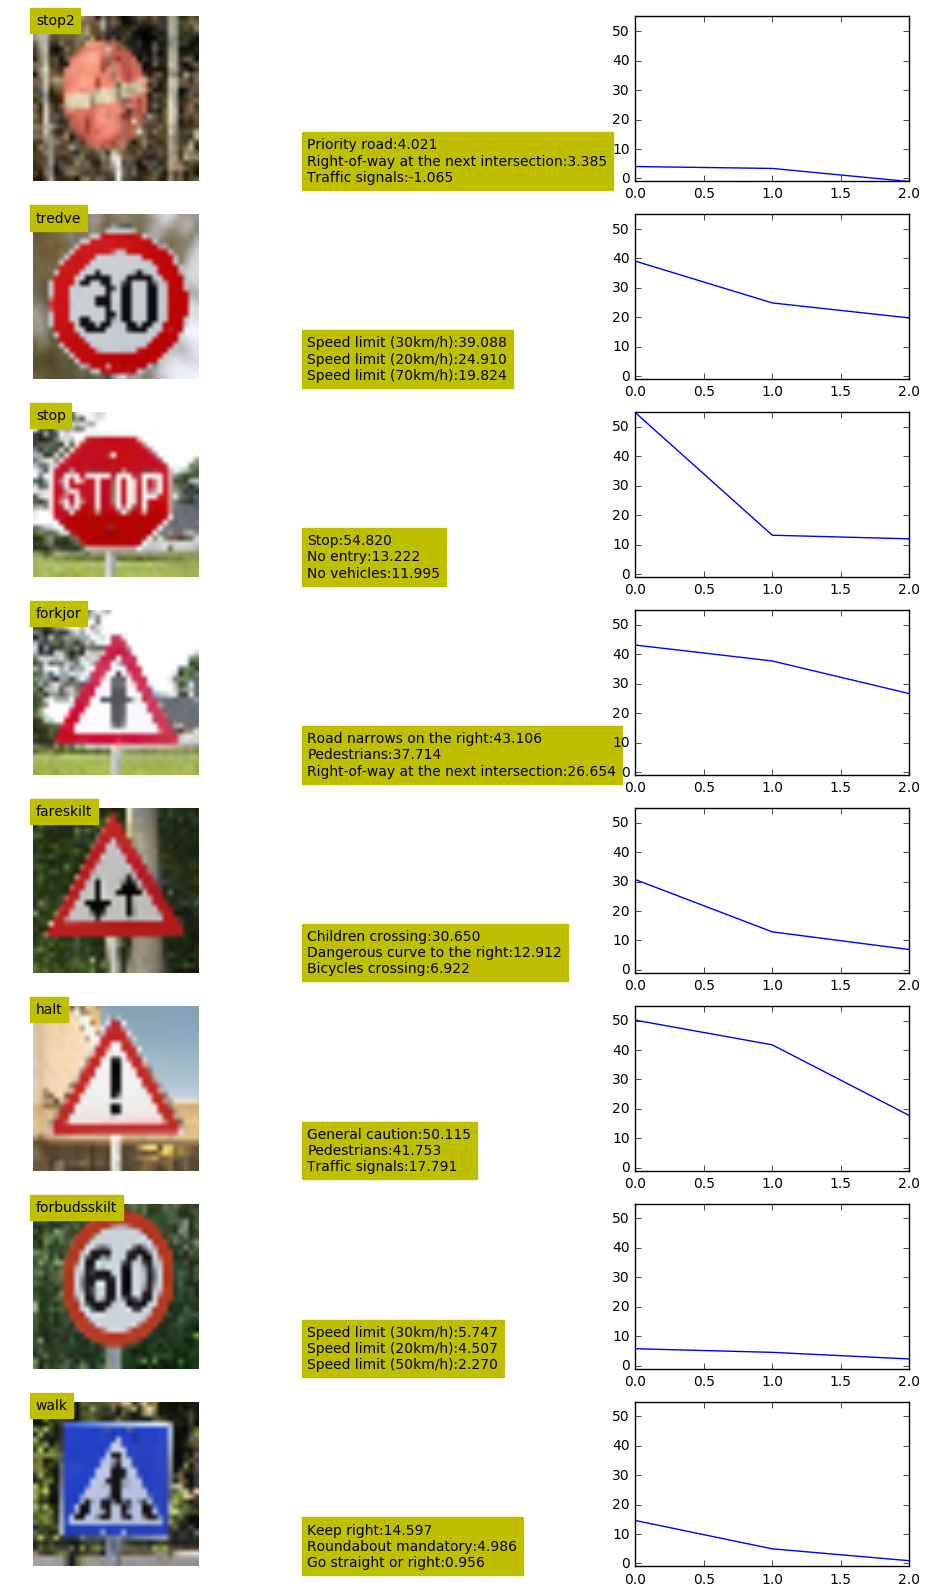

In [34]:
plt.figure(figsize=(12,20))


gs = gridspec.GridSpec(len(newimages), 3)
for i in range(len(newimages)):
    ax1 = plt.subplot(gs[i,0])
    ax1.imshow(newimages[i])
    plt.axis('off')
    ax1.text(0,1,newimagesnames[i].split('ok')[0],color='k',backgroundcolor='y')
    
    
    ac = pd.DataFrame(top_predictions[1][0][0],top_predictions[1][1][i])
    nm = pd.DataFrame(signs['SignName'][top_predictions[1][1][i]])
    m = nm.merge(ac,how='inner',left_index=True,right_index=True)
    ax2 = plt.subplot(gs[i,1])

    plt.axis('off')
    text = '{}:{:.3f}\n{}:{:.3f}\n{}:{:.3f}'.format(signs['SignName'][top_predictions[1][1][i][0]],top_predictions[1][0][i][0],
                                                    signs['SignName'][top_predictions[1][1][i][1]],top_predictions[1][0][i][1],
                                                    signs['SignName'][top_predictions[1][1][i][2]],top_predictions[1][0][i][2]
                                                   )
    ax2.text(0,0,text,color='k',backgroundcolor='y')
    
        
    ax3 = plt.subplot(gs[i,2])
    ax3.set_ylim([-1, 55])
    ax3.plot(top_predictions[1][0][i])
    
    #plt.imshow(newimages[i])
    #print(newimagesnames[i])
    #for j in range(len(top5_pred[1][0][i])):
    #    print('-  ',signs['SignName'][top5_pred[1][1][i][j]],' : ',top5_pred[1][0][i][j])

**Answer:**
The certainties varies a lot. I do not really know how to interpret the "certainty" number returned from tf.nn.top_k.
1. The first sign is a "no entry" sign where the classifier are uncertain. The highest propability is that it is a "stop" sign, with "no entry" as a second guess. The image and sign is miscolored and have some trees that are partly covering the sign, the sign is hard to classify.
1. The second sign is a "30km" sign where the classifier is pretty certain, the picture is in the training set and the picture is clear.
1. The third sign is a "stop" sign where the classifier is pretty certain, the picture is in the training set and the picture is clear.
1. The fourth sign s a "right of way" sign where the classifier is pretty certain. In general the classifier have not been good at giessing this sign, but with this configuration it was pretty certain.
1. The fifth sign is not in the training set, but the classifier the the signs is "childrens crossing"
1. The sixt sign is in the training set, and the classifier guess correctly, but there is not much drop to the next probable sign.
1. Number seven is the most mystical sign for me, the sign is in the training set, but the correct sign rarely guessed. Overall low numbers from the classifier with different configuration.
1. Number eight is not in the training set, and it seem that the color is the most significant cause of guessing.



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.